In [23]:
from ProcessingFunctions import *

In [24]:
VSTPATH = "D:/VST64/Sampler/Kontakt 6 x64/Kontakt 6.dll"
#VSTPATH = "D:/VST64/Synth/Massive/Massive.dll"
SAMPLERATE = 44100
BLOCKSIZE = 2048

KEY_RANGE = ['C1','C3']
VELOCITY_STEPS = [33, 66, 99, 127]  #0...127
ROUND_ROBINS = 5

SAVEPATH = "samples/PLZ_DELET/TTFTStrMnstLowStc"  #<-- also include instrument sample prefix here

In [25]:
plugin = loadVST(VSTPATH,SAMPLERATE,BLOCKSIZE)

In [35]:
configVST(plugin)

In [26]:
plugin.number_of_inputs,plugin.number_of_outputs

(0, 64)

In [27]:
MIDI_KEY = {
    'C-2':0, 'C#-2':1, 'D-2':2, 'D#-2':3, 'E-2':4, 'F-2':5, 'F#-2':6, 'G-2':7, 'G#-2':8, 'A-2':9, 'A#-2':10,'B-2':11,
    'C-1':12,'C#-1':13,'D-1':14,'D#-1':15,'E-1':16,'F-1':17,'F#-1':18,'G-1':19,'G#-1':20,'A-1':21,'A#-1':22,'B-1':23,
    'C0':24, 'C#0':25, 'D0':26, 'D#0':27, 'E0':28, 'F0':29, 'F#0':30, 'G0':31, 'G#0':32, 'A0':33, 'A#0':34, 'B0':35,
    'C1':36, 'C#1':37, 'D1':38, 'D#1':39, 'E1':40, 'F1':41, 'F#1':42, 'G1':43, 'G#1':44, 'A1':45, 'A#1':46, 'B1':47,
    'C2':48, 'C#2':49, 'D2':50, 'D#2':51, 'E2':52, 'F2':53, 'F#2':54, 'G2':55, 'G#2':56, 'A2':57, 'A#2':58, 'B2':59,
    'C3':60, 'C#3':61, 'D3':62, 'D#3':63, 'E3':64, 'F3':65, 'F#3':66, 'G3':67, 'G#3':68, 'A3':69, 'A#3':70, 'B3':71,
    'C4':72, 'C#4':73, 'D4':74, 'D#4':75, 'E4':76, 'F4':77, 'F#4':78, 'G4':79, 'G#4':80, 'A4':81, 'A#4':82, 'B4':83,
    'C5':84, 'C#5':85, 'D5':86, 'D#5':87, 'E5':88, 'F5':89, 'F#5':90, 'G5':91, 'G#5':92, 'A5':93, 'A#5':94, 'B5':95,
    'C6':96, 'C#6':97, 'D6':98, 'D#6':99, 'E6':100,'F6':101,'F#6':102,'G6':103,'G#6':104,'A6':105,'A#6':106,'B6':107,
    'C7':108,'C#7':109,'D7':110,'D#7':111,'E7':112,'F7':113,'F#7':114,'G7':115,'G#7':116,'A7':117,'A#7':118,'B7':119,
    'C8':120,'C#8':121,'D8':122,'D#8':123,'E8':124,'F8':125,'F#8':126,'G8':127
}

In [39]:
fromIdx = 0
toIdx = 127
keys = list(MIDI_KEY.keys())
for idx,curKey in enumerate(keys):
    if curKey == KEY_RANGE[0]: #Lowest note we want to sample
        fromIdx = idx
    if curKey == KEY_RANGE[1]: #Highest note we want to sample
        toIdx = idx+1 #because that's how pythons list index subscripts works bitch (see next line)
keys = keys[fromIdx:toIdx]
sub_midi_dict = {k:v for k,v in MIDI_KEY.items() if k in keys}

In [40]:
for key_name, key_value in sub_midi_dict.items():
    #e.g.: key_name,key_value = G2, 55 ...
    print(key_name,key_value)
for velocity in VELOCITY_STEPS:
    print(velocity)
for rr in range(1,ROUND_ROBINS+1):
    print(rr)

C1 36
C#1 37
D1 38
D#1 39
E1 40
F1 41
F#1 42
G1 43
G#1 44
A1 45
A#1 46
B1 47
C2 48
C#2 49
D2 50
D#2 51
E2 52
F2 53
F#2 54
G2 55
G#2 56
A2 57
A#2 58
B2 59
C3 60
33
66
99
127
1
2
3
4
5


In [30]:
#Note On Event
midiEvent1 = getNoteOnEvent(key=key_value, velocity=velocity, deltaFrames=0, channel=1)
#Merge MidiEvents to VstEventList
midiEventList = []
midiEventList.append(midiEvent1)
mergedMidiEvents = mergeMidiEvents(midiEventList)

In [41]:
#Send events to plugin
sendMidiEventsToPlugin(plugin, mergedMidiEvents)

In [42]:
#Retrieve output for given duration
output = processInstrument(plugin, length=5*SAMPLERATE)

In [33]:
outputL,outputR = gateStereoSample(output[0],output[1],trimFront=False, trimBehind=True, offThreshold=-80, mode='dBFSR')

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
outputL = limitSample(outputL, valdB=-0.1)
outputR = limitSample(outputR, valdB=-0.1)

In [45]:
savefilepath = '_'.join([SAVEPATH,key_name,str(velocity),'rr{}'.format(rr),'.wav'])

In [46]:
outputdata = np.array([output[0], output[1]]).T
scipy.io.wavfile.write(savefilepath, SAMPLERATE, outputdata)

In [55]:
#Send note-off and process (just in case to supress any form of reverb/feedback)
midiEvent2 = getNoteOffEvent(key=key_value, velocity=velocity, deltaFrames=0, channel=1)
midiEvent3 = getNoteOnEvent(key=key_value, velocity=0, deltaFrames=0, channel=1) #Do both types of note-offs
midiEventList = []
midiEventList.append(midiEvent2)
midiEventList.append(midiEvent3)
mergedMidiEvents = mergeMidiEvents(midiEventList)
sendMidiEventsToPlugin(plugin, mergedMidiEvents)
output = processInstrument(plugin, length=5*SAMPLERATE) #don't save this output :p

#### Some plotting

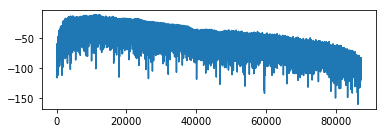

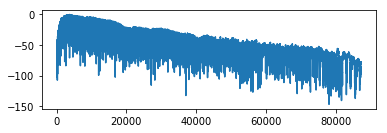

In [20]:
plot_log(outputL,outputR)

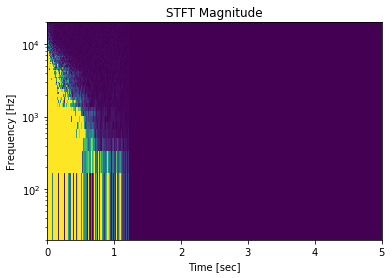

In [43]:
plot_stft(output[0],SAMPLERATE)

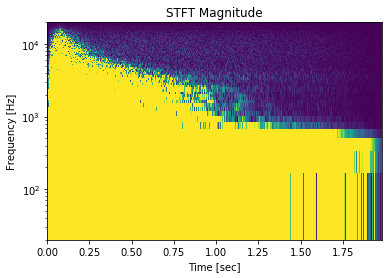

In [22]:
plot_stft(outputL,SAMPLERATE)

In [3]:
valdB=-0.1
valFloat = 10**(valdB/20)
valFloat

0.9885530946569389